# In this notebook look at how cellular representations look when you split them by the direction, in task space, that the subject is moving in

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 
import math
import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/yves/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

In [3]:
from mecll.rsync import Rsync_aligner
from mecll.load import load_data

#  Helper functions

In [4]:
def get_all_transition(seq,graph_type):
    """
    What is says on the tin. Returns a list of strings describing transitions that
    is analogous to what is stored in dataframe obtained by running build_df
    """
    all_transitions = []
    lseq = len(seq)
    if graph_type=='line': s2 = seq[:-1]
    else: s2 = seq
    for kk,pk in enumerate(s2):
        #print(1)
        all_transitions.append(str(pk) + '_' + str(seq[(kk+1)%lseq]))
        if graph_type=='line':
            all_transitions.append(str(seq[(kk+1)%lseq]) + '_' + str(pk))

    if graph_type=='loop':
        for kk,pk in enumerate(s2[::-1]):
            all_transitions.append(str(pk) + '_' + str(seq[::-1][(kk+1)%lseq]))
    return all_transitions

In [5]:
def get_transitions_state(graph_type):
    
    transitions = [[i,i+1] for i in range(8)]
    transitions.extend([[i,i-1] for i in range(1,9)])
    if graph_type=='loop':
        transitions.extend([[0,8],[8,0]])
        
    all_transitions = []
    for kk, pk in enumerate(transitions):
        all_transitions.append(str(pk[0])+'_'+str(pk[1]))
    return all_transitions

In [6]:
def plot_activity_on_graph(sequence,graph_type,order='poke',spks=None,node_size=512,mx=None,direction='both',cmap_='RdBu_r'):
    """ This plots all transitions based on the final sequence
    
    Argument:
    ==============================
    
    order:          str (poke|state)
                    this specifies whether spks in ordered
                    in terms of pokes in physical space or in terms the
                    abstract states in the task and will change how it is plotted accordingly
    
    """
    
    if order=='poke':
        poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])
    elif order=='state':
        x_ = np.linspace(0,2*np.pi,num=9).tolist()
        tmp = np.linspace(0,2*np.pi,num=9)#[x_[i] for i in sequence]
        poke_pos = np.vstack([np.sin(tmp),np.cos(tmp)]).T
    else:
        raise Exception("order argument must be set to either 'poke' or 'state'")


    if spks is None: spks='.3'
        
    G = nx.DiGraph()

    if len(spks)!='.3':
        #cmap_ = 'RdBu_r'
        if mx is None:
            mx = np.max(spks)
        cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0,vmax=mx,clip=True),cmap=cmap_)

        for i in range(9):
            c = spks[i]
            #pos = poke_pos
            if c==np.nan:
                clr = [.3,.3,.3]
            else:
                clr = cmap.to_rgba(c)
            G.add_node(i,pos=poke_pos[i],color=clr)
        
    seq_inv = [sequence.index(i) for i in range(9)]
    if order=='poke':
        all_transitions = get_all_transition(sequence,graph_type)
    elif order=='state':
        all_transitions = get_transitions_state(graph_type)
    
    #print(all_transitions)
    if order=='poke':
        if direction=='both':
            pass
        elif direction==1:
            all_transitions = all_transitions[::2]
        else:
            all_transitions = all_transitions[1::2]
        #print(all_transitions)
        for e in all_transitions:
            #print(all_transitions)
            G.add_edge(int(e[0]),int(e[-1]))

    node_colors = nx.get_node_attributes(G,'color')
    if order=='poke':
        #G.edges
        nx.draw(G,
                pos=poke_pos,edge_color=".3",
                node_color=np.array(list(node_colors.values())),
                node_size=node_size,
                connectionstyle="arc3,rad=-0.1",
                width=2,
                with_labels=False,
                #node_labels=sequence
        )
        label_seq = dict([(i,seq_inv[i]) for i in range(9)])
        nx.draw_networkx_labels(G,poke_pos, label_seq)

    else:
        nx.draw_circular(G,
                         edge_color='.3',
                         node_color=np.array(list(node_colors.values())),
                         node_size=node_size,
                        connectionstyle="arc3,rad=-0.1",
                        width=2,
                        with_labels=False)
        label_seq = dict([(seq_inv[i],i) for i in range(9)])
        pos_ = nx.drawing.layout.circular_layout(G)
        nx.draw_networkx_labels(G,pos_, label_seq)


In [7]:
def get_angle_between_ports(port1_id,port2_id):
    port1_id = np.flipud(poke_pos[port1_id])
    port2_id = np.flipud(poke_pos[port2_id])
    myradians = np.math.atan2(port1_id[0]-port2_id[0],port1_id[1]-port2_id[1])
    angle = myradians*(180/np.pi)
    return angle


In [8]:
def build_poke_df(lines,events,sync_thing=0):
    
    df = pd.DataFrame(columns=['target','port','state','task_nr','direction','in_timeout','n_timeouts','probe','correct',
                               'previous_port','previous_state','reward','block_nr','task_repeat_nr','port_repeat',
                               'incoming_angle','outgoing_angle','next_correct'
                               'frac_corr','response_time','time','current_sequence','graph_type' #behavioural variables
                              ]) 
    
    all_poke_dict = []
    poke_dict = None
    target_hist = []
    rew_hist = []
    current_block_number = -1
    RT = None
    for ctr_,l in enumerate(lines):
        if 'task_number'in l:
            #if poke_dict is not None:
            #    all_poke_dict.append(cp.deepcopy(poke_dict))
            #poke_dict = {}
            current_block_number += 1
            current_task = re.findall(r'task_number([0-9])',l)[0]
            current_sequence = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            current_graph_type = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]
            #poke_dict['task_nr'] = re.findall(r'task_number([0-9])',l)[0]
            #poke_dict['seq'] = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            #print(lines[ctr_+2],poke_dict.keys())
            #poke_dict['graph_type'] = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]

        if 'REW_IN_SEQ' in l:
            t_ = int(re.findall(r'P ([0-9]*)',l)[0])# + sync_thing
            poke = re.findall('POKED: ([0-9])',l)[0]
            target = re.findall('TARGET: ([0-9])',l)[0]
            n_rew_in_seq = int(re.findall('REW_IN_SEQ:([0-9]*)',l)[0])
            direction = int(re.findall('DIR: (\-*\d+)',l)[0])
            #print(direction)
            
            if len(df)>0:
                previous_port = df.iloc[-1]['port']
                incoming_angle = get_angle_between_ports(int(poke),int(previous_port))
                if not df.iloc[-1]['correct']:
                    current_is_repeat = True
                    incoming_angle = None
                    df.loc[len(df)-2,'next_correct'] = False

                else:
                    current_is_repeat = False
                    df.loc[len(df)-2,'next_correct'] = True


                    
            else:
                previous_port = None
                current_is_repeat = False
                incoming_angle = None
            
            n_rew =  int(re.findall('REWS:([0-9]*)',l)[0])
            #print(l)
            probe = bool(re.findall('PROBE: ([True|False])',l)[0]=='T')
            rew_hist.append(n_rew)
            target_hist.append(target)
            
                
                
            
            #print(current_sequence)
            if len(rew_hist)>1:
                if len(df)>1:
                    if current_is_repeat:
                        RT = None
                    else:
                        df.loc[len(df)-1,'outgoing_angle'] = incoming_angle
                        RT = t_ - df.iloc[-1]['time']
                    
                
                poke_dct = {
                          'target': int(target),
                          'port': int(poke),
                          'state': current_sequence.index(int(poke)),
                          'task_nr': current_task,
                          'direction': direction,
                          'in_timeout': False,
                          'n_timeouts': np.nan,
                          'probe': probe,
                          'correct': poke==target,
                          'reward': n_rew==rew_hist[-2],
                          'block_nr':current_block_number,
                          'task_repeat_nr': int(np.floor(current_block_number/2)),
                          'frac_corr': None,
                          'response_time':RT,
                          'time':t_,
                          'current_sequence': current_sequence,
                          'graph_type': current_graph_type,
                          'port_repeat':current_is_repeat,
                          'incoming_angle': incoming_angle,
                          'outgoing_angle': None,
                          'previous_port': previous_port
                                  }
                df = df.append(poke_dct,ignore_index=True)
                    
       
    return df
    

In [9]:
p1 = np.flipud(poke_pos[4])
p2 = np.flipud(poke_pos[0])
print(p1,p2)
myradians = math.atan2(p1[0]-p2[0],p1[1]-p2[1])
print(myradians*(180/np.pi))

[-62 149] [  0 149]
-90.0


In [10]:
def get_in_task_pokes(lines,events,sync_thing=0):
    """ This builds a list of dictionaries about what happened in the task.
        Each dictionary contains the times of pokes in each of the ports 
        and some metadata about the currenct task (e.g. the structure of
        the current task [line or loop] and the sequence of ports). The mouse
        does the task in blocks that alternate between the two structures it has
        learned. Each block has its own dictionary.
        """
    all_poke_dict = []
    poke_dict = None
    target_hist = []
    rew_hist = []
    for ctr_,l in enumerate(lines):
        if 'task_number'in l:
            if poke_dict is not None:
                all_poke_dict.append(cp.deepcopy(poke_dict))
            poke_dict = {}
            poke_dict['task_nr'] = re.findall(r'task_number([0-9])',l)[0]
            poke_dict['seq'] = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            #print(lines[ctr_+2],poke_dict.keys())
            poke_dict['graph_type'] = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]

        if 'REW_IN_SEQ' in l:
            t_ = int(re.findall(r'P ([0-9]*)',l)[0])# + sync_thing
            poke = re.findall('POKED: ([0-9])',l)[0]
            target = re.findall('TARGET: ([0-9])',l)[0]
            n_rew_in_seq = int(re.findall('REW_IN_SEQ:([0-9]*)',l)[0])
            direction = int(re.findall('DIR: (\-*\d+)',l)[0])
            #print(direction)
            
            n_rew =  int(re.findall('REWS:([0-9]*)',l)[0])
            #print(l)
            probe = bool(re.findall('PROBE: ([True|False])',l)[0]=='T')
            rew_hist.append(n_rew)
            target_hist.append(target)
            #print(poke,target)
            if len(target_hist)>3:
                if (poke==target and 
                    #target!=target_hist[-2] and 
                    n_rew_in_seq>5 and
                    direction==1 and
                    n_rew==rew_hist[-2] and
                    probe==False):
                    #print(poke)
                    if poke in poke_dict.keys():
                        poke_dict[poke].append(t_)
                    else:
                        poke_dict[poke] = [t_]
                    #poke_dict[poke]
    all_poke_dict.append(poke_dict)
    return all_poke_dict

In [12]:
def plot_cell(ix,all_resps_g1,all_resps_g2,all_poke_dict,norm=False,norm_pct=90):
    plt.figure(figsize=(12,4))
    n_plot = 1
    ctr = 0
    resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
    resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]

    if norm:
        mx = np.percentile(np.concatenate([all_resps_g1[ix],all_resps_g2[ix]]),norm_pct)
    else:
        mx = None
    plt.subplot(n_plot,4,4*ctr+1)
    spks = all_resps_g1[ix]
    plot_activity_on_graph(all_poke_dict[0]['seq'],'line',spks=spks,order='poke',mx=mx)
    plt.subplot(n_plot,4,4*ctr+2)
    spks = all_resps_g2[ix]
    plot_activity_on_graph(all_poke_dict[1]['seq'],'line',spks=spks,order='poke',mx=mx)

    plt.subplot(n_plot,4,4*ctr+3)
    spks = resps_state_g1[ix]
    plot_activity_on_graph(all_poke_dict[0]['seq'],'line',spks=spks,order='state',mx=mx)
    plt.subplot(n_plot,4,4*ctr+4)
    spks = resps_state_g2[ix]
    plot_activity_on_graph(all_poke_dict[1]['seq'],'line',spks=spks,order='state',mx=mx)
    
    ctr +=1

In [19]:
#Load behavioural data
root_path = '/Users/yves/team_mouse Dropbox/MEC_data/spike_sorted/2021-08-06_39964_ks25/'
#'/Users/yves/Downloads/example_files2_wOF//'

out = load_data(root_path)
spkT,spkC,single_units,events,lines,aligner = out

df = build_poke_df(lines,events)


567 567


In [20]:
#process task data
all_poke_dict = get_in_task_pokes(lines,events)

In [21]:
df = build_poke_df(lines,events)


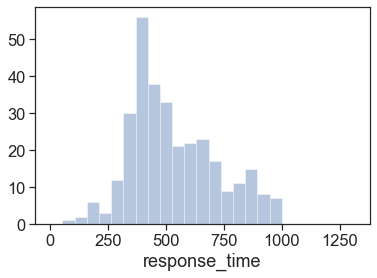

In [22]:
# Plot the time between successive inpokes
seaborn.distplot(df['response_time'][np.isfinite(df['response_time'].values.astype("float"))],
                 kde=0,bins=np.linspace(0,1000,num=20))

In [23]:
# Build dicts that store pokes going in different directions

unique_directions = np.unique(df['direction'])
poke_dict_t1 ={}
poke_dict_t2 = {}

direction = 'both'
for port_nr in np.unique(df['port'].values):
    for direction in unique_directions[::-1]:
        task_nr = str(0)
        v = df.loc[(df['port']==port_nr) &
                   (df['correct']==True) & 
                  # (df['port_repeat']==False) & 
                  # (df['next_correct']==True) &
                  # (df['reward']==False) &          
                   (df['task_nr']==task_nr) &
                   #(df['probe']==False) &
                   (df['direction']==direction)]['time'].values
        #v = np.array(v).astype('float')
        if direction==unique_directions[0]:
            print(task_nr,len(v),str(port_nr))
            poke_dict_t1[str(port_nr)] = [float(i) for i in v]
            
            poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
            poke_dict_t1['direction'] = direction

        else:
            poke_dict_t2[str(port_nr)] = [float(i) for i in v]
            
            poke_dict_t2['task_nr'] = str(task_nr)
            poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
            poke_dict_t2['direction'] = direction

        

        


0 16 0
0 19 1
0 14 2
0 21 3
0 17 4
0 0 5
0 14 6
0 20 7
0 0 nan
0 20 7
0 10 8


In [24]:
def get_all_resps(aligner,poke_dict,single_units,spkT,spkC,window0=3000,window1=6000):
    """ This code gets the average response of all cells to pokes in a single task block
    """
    all_resps = []
    all_resps1 = []
    all_resps2 = []
    scaleF = (window0+window1)/30000.
    
    for unit in single_units:#[n_:n_+1]:  #loop over all cells
        
        spk_unit = spkT[np.where(spkC==unit)[0]] #select all spikes that belong to this cell
        
        resps = [[] for _ in range(9)]
        resps1 = [[] for _ in range(9)]
        resps2 = [[] for _ in range(9)]
        for key,vals in poke_dict.items():  #loop over pokes
            if re.findall('[0-9]',key): #ignore dictionary items that are metadata like the sequence and graph time
                aligned_T = aligner.B_to_A(vals) #align pokes into spike times

                #get the pokes that are in bounds for position encoding
                pks_unit_in_bounds = np.where(np.logical_not(np.isnan(aligned_T)))[0]
                
                used_pks = aligned_T[pks_unit_in_bounds].astype('int') #get pokes aligned with spike times
                key = int(key)
                half_npks = int(len(used_pks)/2)
                #print(key,half_npks)
                for pk_ix,tpk in enumerate(used_pks):  #loop over all pokes to a given port
                    
                    #this is a block of code to split the data in half, useful for looking at stability when you
                    #only have one task block
                    nSpikes = len(np.where(np.logical_and(spk_unit>(tpk-window0),spk_unit<(tpk+window1)))[0])
                    firing_rate = scaleF*float(nSpikes)
                    
                    if pk_ix<=half_npks:
                        resps2[key].append(firing_rate)
                        
                    else:
                        resps1[key].append(firing_rate)

                    resps[key].append(firing_rate)

                    
                    
        all_resps.append(resps.copy())
        all_resps1.append(resps1.copy())
        all_resps2.append(resps2.copy())
        
    return all_resps, [all_resps1,all_resps2]

In [25]:
def get_mean_resps(all_resps_single_trial):
    mus = []
    vs = []
    mu_g1 = []
    var_g1 = []
    for neuron in all_resps_single_trial:
        tmp_mu = []
        tmp_var = []
        for poke in neuron:
            if len(poke)==0:
                tmp_mu.append(np.nan)
                tmp_var.append(np.nan)
            else:
                tmp_mu.append(np.mean(poke))
                tmp_var.append(np.var(poke))
        mu_g1.append(tmp_mu)
        var_g1.append(tmp_var)

    return np.array(mu_g1),np.array(var_g1)

In [26]:
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial) = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC)

In [27]:
all_resps_g1,_ = get_mean_resps(all_resps_g1_single_trial)
all_resps_g2,_ = get_mean_resps(all_resps_g2_single_trial)


all_resps1_g1,_ = get_mean_resps(all_resps1_g1_single_trial)
all_resps1_g2,_ = get_mean_resps(all_resps1_g2_single_trial)

all_resps2_g1,_ = get_mean_resps(all_resps2_g1_single_trial)
all_resps2_g2,_ = get_mean_resps(all_resps2_g2_single_trial)

In [28]:
# For some reason calculate the anlges subjects are going in, doesn't seem to relate to the same code
seq1 =poke_dict_t1['seq']
print(seq1)
angles_seq1 = np.round(np.array([get_angle_between_ports(seq1[i+1],seq1[i]) for i in range(len(seq1)-1)])%360,decimals=2)

seq1 =poke_dict_t1['seq']
print(seq1)
angles_seq2 = np.round(np.array([get_angle_between_ports(seq1[i],seq1[i+1]) for i in range(len(seq1)-1)])%360,decimals=2)



[0, 2, 4, 3, 6, 8, 7, 1, 5]
[0, 2, 4, 3, 6, 8, 7, 1, 5]


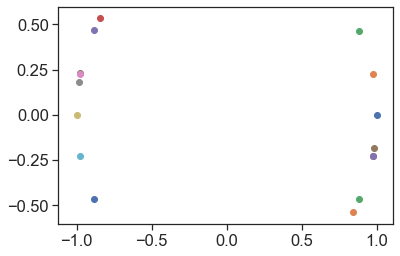

In [29]:
# plot the anlges from above
for uniq_ang in np.unique(np.concatenate([angles_seq1,angles_seq2])):
    plt.scatter(np.cos(np.pi*uniq_ang/180),np.sin(np.pi*uniq_ang/180))

In [30]:
# bin the anlges by egocentric heading direction
neuron_ix = 28
#angle_bin_width = 60
unique_angles = np.unique(np.concatenate([angles_seq1,angles_seq2]))
resp_by_angle = np.zeros(len(unique_angles))
for i,ang in enumerate(unique_angles):
    if ang in angles_seq1:
        resp_by_angle[i] = all_resps_g1[neuron_ix,angles_seq1.tolist().index(ang)]
    elif ang in angles_seq1:
        resp_by_angle[i] = all_resps_g2[neuron_ix,angles_seq1.tolist().index(ang)]


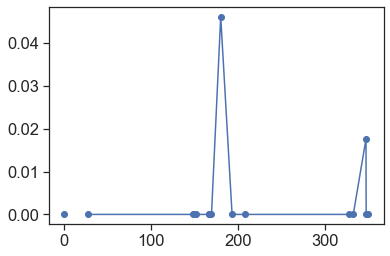

In [31]:
plt.plot(unique_angles,resp_by_angle,marker='o')

In [49]:
neuron_ix = 12
angle_bin_width = 60
resp_by_angle = np.zeros(int(360/angle_bin_width))
for i,ang in enumerate(range(0,360,angle_bin_width)):
    in_ang1 = np.where(np.logical_and(angles_seq1>=ang,angles_seq1<(ang+angle_bin_width)))[0]
    tmp = all_resps_g1[neuron_ix,in_ang1].tolist()
    in_ang2 = np.where(np.logical_and(angles_seq2>=ang,angles_seq2<(ang+angle_bin_width)))[0]
    print(len(in_ang1),len(in_ang2),ang)
    tmp.extend(all_resps1_g2[neuron_ix,in_ang1].tolist())
    resp_by_angle[i] = np.nanmean(tmp)
    
    

1 0 0
2 1 60
2 2 120
0 1 180
1 2 240
2 2 300


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


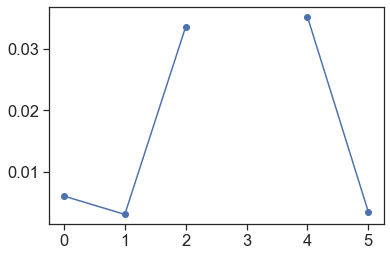

In [50]:
plt.plot(resp_by_angle,marker='o')

In [51]:
#
ccs_within1 = []
for r1,r2 in zip(all_resps1_g1,all_resps2_g1):
    valid = np.logical_and(np.isfinite(r1),np.isfinite(r2))
    ccs_within1.append(np.corrcoef(r1[valid],r2[valid])[0,1])
    
ccs_within1 = np.array(ccs_within1)
print(np.nanmean(ccs_within1))

0.5410841161211964


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [52]:
#
ccs_within2 = []
for r1,r2 in zip(all_resps1_g2,all_resps2_g2):
    valid = np.logical_and(np.isfinite(r1),np.isfinite(r2))
    ccs_within2.append(np.corrcoef(r1[valid],r2[valid])[0,1])
ccs_within2 = np.array(ccs_within2)

print(np.nanmean(ccs_within2))

0.5702087500772531


In [53]:
ccs_within = (np.array(ccs_within1) + np.array(ccs_within2))/2.
ccs_within = np.min(np.vstack([np.array(ccs_within1),np.array(ccs_within2)]),axis=0)

In [54]:
#
ccs_across = []
for r1,r2 in zip(all_resps_g1,all_resps_g2):
    valid = np.logical_and(np.isfinite(r1),np.isfinite(r2))
    ccs_across.append(np.corrcoef(r1[valid],r2[valid])[0,1])
    
ccs_across = np.array(ccs_across)
print(np.nanmean(ccs_across))

0.5198084281695258


Text(0, 0.5, 'within_task2 stability')

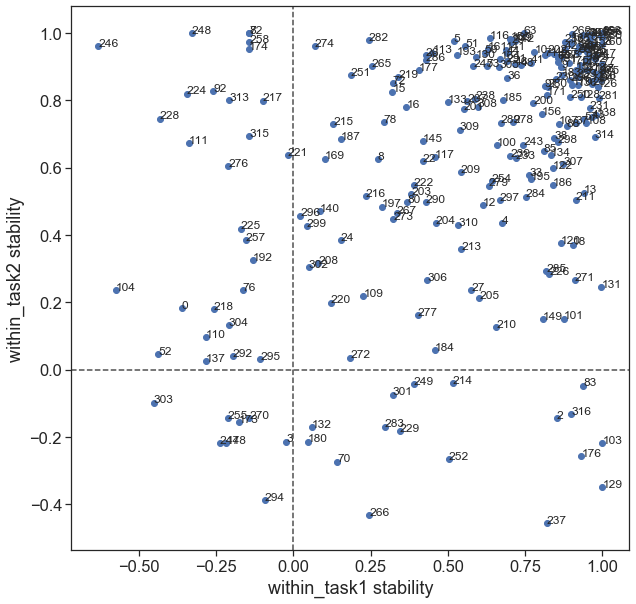

In [55]:
plt.figure(figsize=(10,10))
plt.scatter(ccs_within1,ccs_within2)
plt.axvline(x=0,color='.3',linestyle='--')
plt.axhline(y=0,color='.3',linestyle='--')
for i, txt in enumerate(ccs_across):
    plt.gca().annotate(i, (ccs_within1[i], ccs_within2[i]),fontsize=12)

plt.xlabel('within_task1 stability')
plt.ylabel('within_task2 stability')

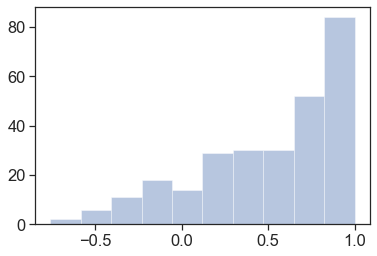

In [58]:
seaborn.distplot(np.array(ccs_across)[np.isfinite(ccs_across)],kde=0)

Text(0, 0.5, 'within_task_stability')

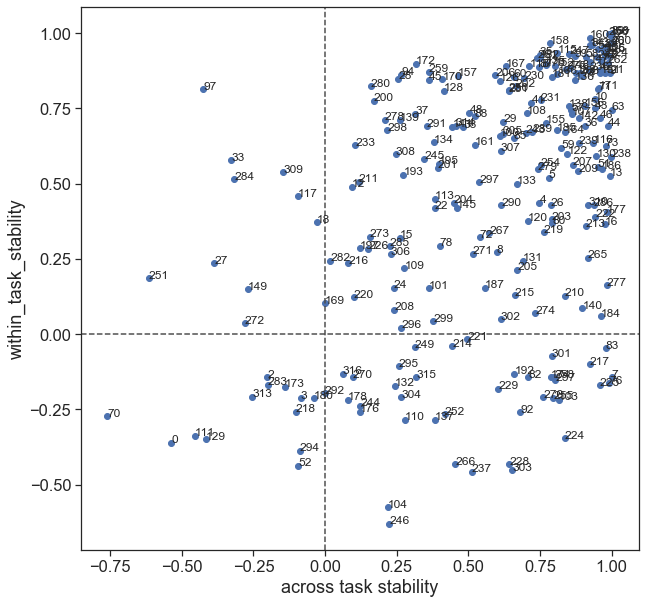

In [59]:
plt.figure(figsize=(10,10))
plt.scatter(ccs_across,ccs_within)
plt.axvline(x=0,color='.3',linestyle='--')
plt.axhline(y=0,color='.3',linestyle='--')
for i, txt in enumerate(ccs_across):
    plt.gca().annotate(i, (ccs_across[i], ccs_within[i]),fontsize=12)

plt.xlabel('across task stability')
plt.ylabel('within_task_stability')

# Calculate ROC-AUC scores that determine how well you can tell which direction subjects are heading in within a task

In [65]:
from sklearn.metrics import roc_auc_score

In [66]:
rocs = []
for neuron_g1,neuron_g2 in zip(all_resps1_g1_single_trial,all_resps1_g2_single_trial):
    a_ = np.concatenate(neuron_g1)
    b_ = np.concatenate(neuron_g2)
    rocs.append(roc_auc_score(np.concatenate([np.ones_like(a_),np.zeros_like(b_)]),np.concatenate([a_,b_])))
rocs = np.array(rocs)

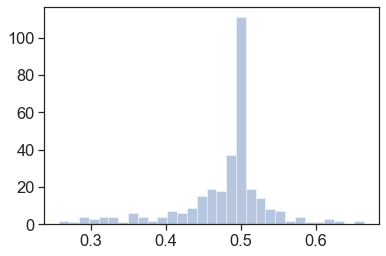

In [67]:
seaborn.distplot(rocs,kde=0)

In [68]:
np.min(rocs)

0.2579331046312178

In [69]:
np.min(rocs)+.5

0.7579331046312179

In [70]:
np.max(rocs)

0.6632075471698113

In [71]:
np.argmax(np.abs(rocs-.5))

60

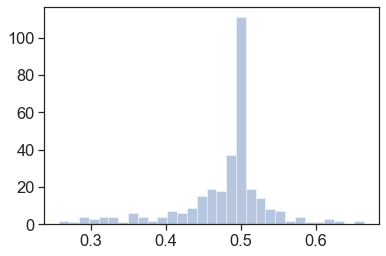

In [72]:
seaborn.distplot(rocs,kde=0)

# Plot activity as a function of direction

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


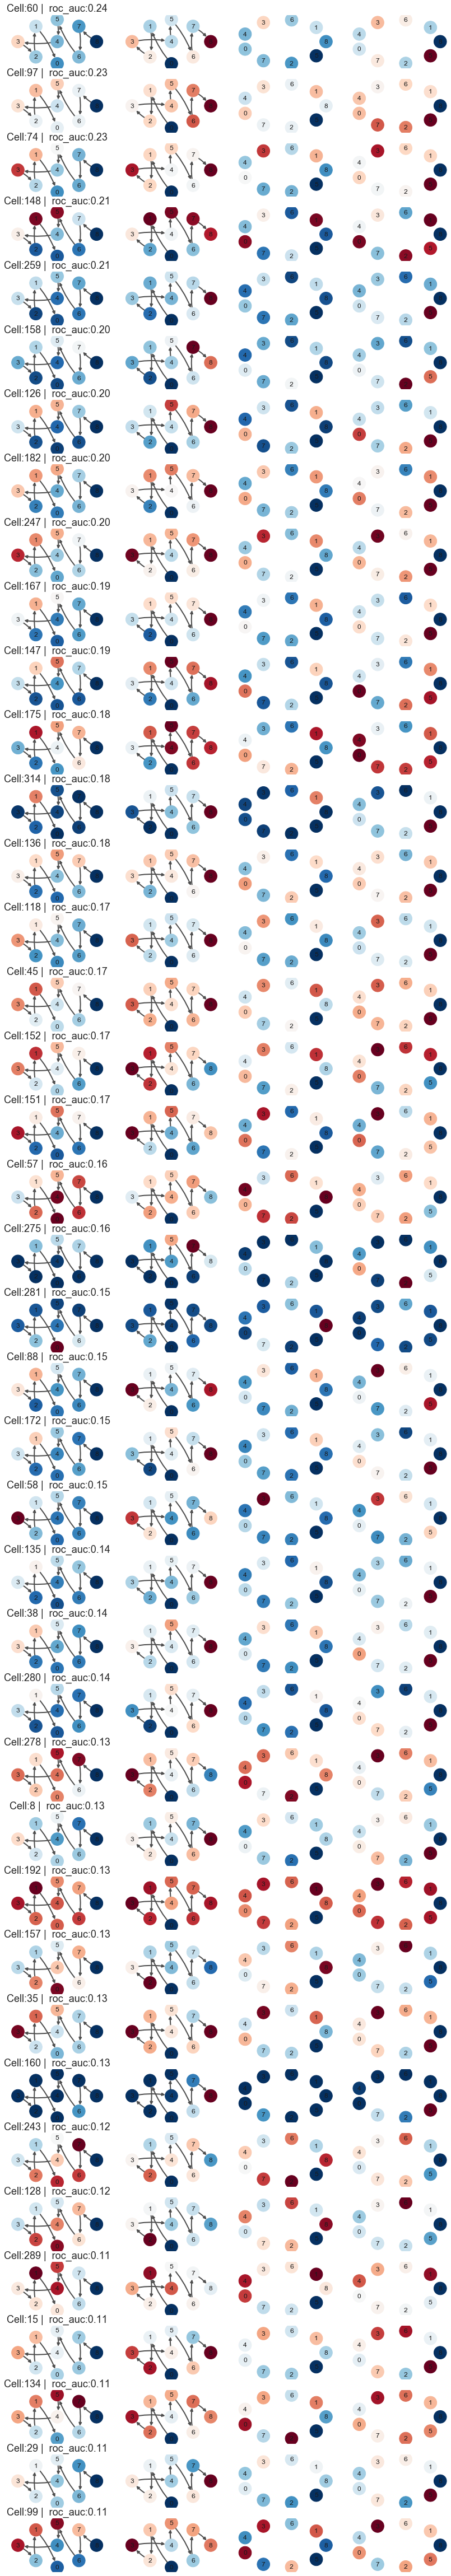

In [75]:
CMAP = 'RdBu_r'
resps_state_g1 = all_resps_g1[:,poke_dict_t1['seq']]
resps_state_g2 = all_resps_g2[:,poke_dict_t2['seq']]
plt.figure(figsize=(14,84))

n_plot = 40
start = 80
ctr = 0
for i in np.argsort(np.abs(rocs-.5))[::-1]:
    if ctr>=n_plot:
        break
    if True:#ccs_within[i]>-1 and ccs_across[i]<1:
        mx = np.nanmax(np.concatenate([all_resps_g1[i],all_resps_g2[i]]))
        plt.subplot(n_plot,4,4*ctr+1)
        plt.title('Cell:{} |  roc_auc:{:.2f}'.format(i,np.abs(rocs-.5)[i]))

        spks = all_resps_g1[i]
        plot_activity_on_graph(poke_dict_t1['seq'],poke_dict_t1['graph_type'],
                               spks=spks,order='poke',mx=mx,direction=poke_dict_t1['direction'],
                               cmap_=CMAP)
        plt.subplot(n_plot,4,4*ctr+2)
        spks = all_resps_g2[i]
        plot_activity_on_graph(poke_dict_t2['seq'],poke_dict_t2['graph_type'],
                               spks=spks,order='poke',mx=mx,direction=poke_dict_t2['direction'],
                               cmap_=CMAP)

        plt.subplot(n_plot,4,4*ctr+3)
        spks = resps_state_g1[i]
        plot_activity_on_graph(poke_dict_t1['seq'],poke_dict_t1['graph_type'],
                               spks=spks,order='state',mx=mx,direction=poke_dict_t1['direction'],
                               cmap_=CMAP)
        plt.subplot(n_plot,4,4*ctr+4)
        spks = resps_state_g2[i]
        plot_activity_on_graph(poke_dict_t2['seq'],poke_dict_t2['graph_type'],
                               spks=spks,order='state',mx=mx,direction=poke_dict_t2['direction'],
                              cmap_=CMAP)

        ctr +=1
        
        
plt.show()